# Hands-on Day 1

- course [slides](https://github.com/leggerf/MLCourse-2021/blob/master/Slides/Day1/Big%20data%20science%20-%20Day%201%20-%202021.pdf)

# You'll learn

- familiarize with jupyter notebooks, numpy and pandas

## Input data
- efficient data format: convert CSV to Parquet
- create input vector with features for MLLib. Format of the input depends on chosen ML library

## Visualization
- explore dataset, plot features
- correlation matrix


# Dataset description

The dataset used in this example is described [here](https://archive.ics.uci.edu/ml/datasets/HIGGS). It is a binary classification problem where the goal is to train a classifier able to distinguish between a signal process, the production of new theoretical Higgs bosons, and a background process with identical decay products but distinct kinematic features.

Each row of this dataset contains 28 features plus the label:

- 21 low-level features which represent the basic measure made by the particle detector
 -        Momentum of the observed paricles
 -        Missing transverse momentum
 -        Jets and b-tagging information
- 7 high-level features computed from the low-level features that encode the knowledge of the different intermediate states of the two processes (reconstructed invariant masses)

## Prepare the execution environment

Your code will run on a single dedicated server with 24 cores (hyperthreading enabled) and 192 GB of RAM. 
All the services needed for this tutorial are deployed as Kubernetes applications on this server. These include:
* JupytherHub
* Jupyter single-user servers
* the HDFS file-system
* Spark Clusters on demand 

#### Load custom magics definition

We load an external file implemanting some custom *magics* function. Have a look at it.

In [1]:
%reload_ext custom_magics

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Check out these custom functions
from custom_functions import *

#### Load the Spark context

We use the custom magic *%sc* to load a pre-defined Spark context.

In [3]:
num_workers=5
spark=%sc $num_workers

from pyspark.sql import SparkSession
spark_session = SparkSession(spark)

#check if spark is there
spark

<SparkContext master=k8s://https://192.168.2.39:6443 appName=jupyter-leggerf>

# Exercise 1

## Get familiar with kubernetes commands

- You can open a terminal and use the commands: 
    `kubectl get pods`
    `kubectl describe pod PODNAME`
    `kubectl get nodes`
    `kubectl describe node NODENAME`
    `kubectl describe farm`
to see what's happening there. 

- Try to stop spark with `spark.stop()`, and start it again running the cell above with a different number of workers. What happens? You can play with the number of workers, and run the cells below that execute spark commands. Provided you're getting all the workers you're asking for, does the execution time change? Try to make some scaling tests.
- if you don't stop spark correctly, you will see pods in Error state. You can get rid of those by running this command:
    `kubectl get pods -n YOURUSERNAME | grep Error | awk '{print $1}' | xargs kubectl delete pod -n YOURUSERNAME`

## Create parquet files, which are faster to read than CSV

Read [here](https://operational-intelligence.web.cern.ch/DataFormats) for a description of the most common data formats and their use

In [4]:
# read from HDFS
inputFile = 'hdfs://192.168.2.39/data/Higgs1M.csv'

%time df = spark_session.read.format('csv').option('header', 'true').option('inferschema', 'true').load(inputFile)

CPU times: user 70.7 ms, sys: 21.9 ms, total: 92.6 ms
Wall time: 16.2 s


In [5]:
#write parquet
hdfs_path=%hdfs_path
outputFile = hdfs_path+'/Higgs1M.parquet'

df.write.parquet(outputFile, mode='overwrite')

## Read in parquet files

how much faster is it to read parquet files rather than csv?

In [6]:
inputFile = 'hdfs://192.168.2.39/data/Higgs10M.parquet'
#inputFile = 'hdfs://192.168.2.39/data/Higgs1M.parquet'
#inputFile = 'hdfs://192.168.2.39/data/Higgs100k.parquet'
#other files are: Higgs1M.parquet, Higgs100k.parquet

%time df = spark_session.read.format('parquet').option('header', 'true').option('inferschema', 'true').load(inputFile)

CPU times: user 7.04 ms, sys: 4.05 ms, total: 11.1 ms
Wall time: 787 ms


In [7]:
#In how many partitions is the dataframe distributed?
print("Number of partitions: {}".format(df.rdd.getNumPartitions()))
print("Partitioner: {}".format(df.rdd.partitioner))

Number of partitions: 26
Partitioner: None


# Exercise 2

## Get familiar with spark workers

- Try to stop spark with `spark.stop()`, and start it again running the cell above with a different number of workers. What happens when you run `kubectl get pods`? 
- You can play with the number of workers, and run any of the cells that execute spark commands. Provided you're getting all the workers you're asking for, does the execution time change? Try to make some scaling tests

# Now let's have a look at the input data

In [8]:
%time total_events = df.count()

print('There are '+str(total_events)+' events')

CPU times: user 63.8 ms, sys: 19.2 ms, total: 83 ms
Wall time: 1.19 s
There are 9560096 events


In [9]:
df.printSchema()

root
 |-- label: double (nullable = true)
 |-- lepton_pT: double (nullable = true)
 |-- lepton_eta: double (nullable = true)
 |-- lepton_phi: double (nullable = true)
 |-- missing_energy_magnitude: double (nullable = true)
 |-- missing_energy_phi: double (nullable = true)
 |-- jet1_pt: double (nullable = true)
 |-- jet1_eta: double (nullable = true)
 |-- jet1_phi: double (nullable = true)
 |-- jet1_b-tag: double (nullable = true)
 |-- jet2_pt: double (nullable = true)
 |-- jet2_eta: double (nullable = true)
 |-- jet2_phi: double (nullable = true)
 |-- jet2_b-tag: double (nullable = true)
 |-- jet3_pt: double (nullable = true)
 |-- jet3_eta: double (nullable = true)
 |-- jet3_phi: double (nullable = true)
 |-- jet3_b-tag: double (nullable = true)
 |-- jet4_pt: double (nullable = true)
 |-- je4_eta: double (nullable = true)
 |-- jet4_phi: double (nullable = true)
 |-- jet4_b-tag: double (nullable = true)
 |-- m_jj: double (nullable = true)
 |-- m_jjj: double (nullable = true)
 |-- m_lv: 

# Exercise 3

- Create a function that makes a plot of any of the above variable for signal versus background (using the label variable to discriminate)
  - see an example of the plot in the hands-on [slides](https://github.com/leggerf/MLCourse-1920/blob/master/Slides/Day1/ML-handson-day1.pdf)
  - the function should take as input the dataframe *df* and the variable name. For example `plotSignalvsBg(df, 'm_bb')`
  - to develop the code, use the 100k dataset, so that debugging goes quicker
- try to plot a few input variables and try to understand which ones are more promising to distinguish signal from background  

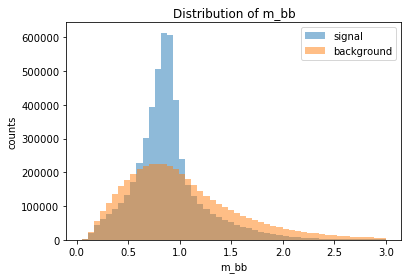

In [10]:
#plot invariant mass distribution 
plotSignalvsBg(df, 'm_bb')

# Exercise 4 - Bonus

#### Create the input feature vector

- Libraries for ML tipically take as inputs data in a very specific format. Documentation on how to do data preprocessing in Spark: https://spark.apache.org/docs/latest/ml-features.html
- Try to add to the dataframe df a new column, called 'features' which is a vector column with all the variables above except for 'label'
   - features = [lepton_pT, lepton_eta, lepton_phi, ...]
   - Hint: look at the VectorAssembler transformer

In [11]:
#create input vector for ML (features)
feature = df.columns
feature.remove('label')

#VectorAssembler is a transformer that combines a given list of columns into a single vector column
assembler = VectorAssembler(inputCols=feature, outputCol='features')
df = assembler.transform(df)

#take a look at how there is now a features column
display(df)
df.select('features').take(1)

#note also that features are already standardised between -1 and 1, so rescaling won't be needed

DataFrame[label: double, lepton_pT: double, lepton_eta: double, lepton_phi: double, missing_energy_magnitude: double, missing_energy_phi: double, jet1_pt: double, jet1_eta: double, jet1_phi: double, jet1_b-tag: double, jet2_pt: double, jet2_eta: double, jet2_phi: double, jet2_b-tag: double, jet3_pt: double, jet3_eta: double, jet3_phi: double, jet3_b-tag: double, jet4_pt: double, je4_eta: double, jet4_phi: double, jet4_b-tag: double, m_jj: double, m_jjj: double, m_lv: double, m_jlv: double, m_bb: double, m_wbb: double, m_wwbb: double, features: vector]

[Row(features=DenseVector([1.1941, 0.1694, 0.8405, 0.6354, -0.7743, 0.592, 1.1803, -0.612, 0.0, 0.7106, -0.6546, 0.7717, 2.2149, 0.5704, -0.0071, -1.3099, 2.5482, 0.5788, 1.7618, -1.5618, 0.0, 0.7988, 0.7121, 1.1986, 0.7594, 0.6849, 0.8257, 0.7558]))]

Print (or draw) the correlation matrix (a table showing correlation coefficients between variables)

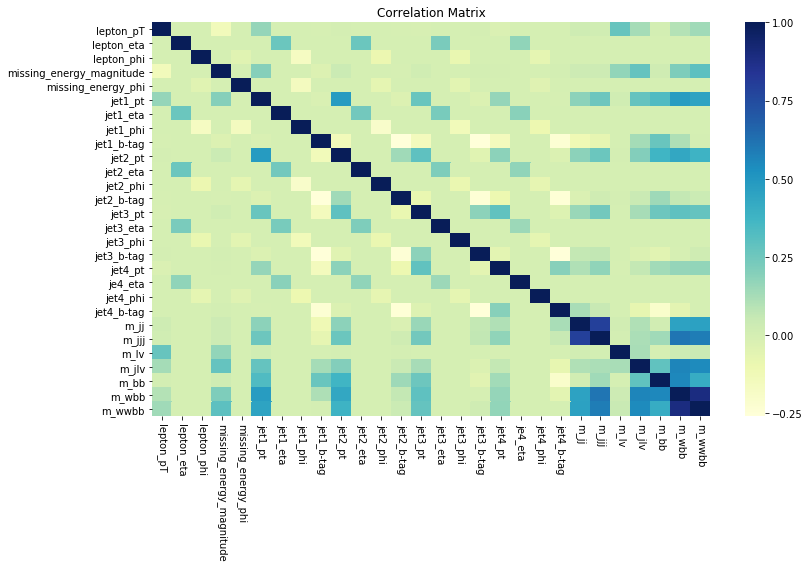

In [12]:
plotCorrelation(df, feature)

In [14]:
#when you're done, stop spark, this will release the resources you're using
spark.stop()